In [20]:

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv

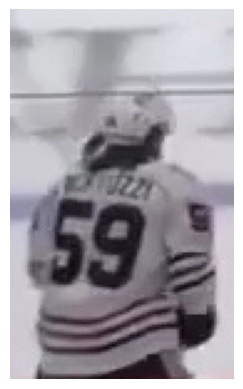

In [3]:
file = '../output_videos/player_327_cropped.jpg'

# Read the image
img = cv2.imread(file)
# Convert BGR to RGB (OpenCV uses BGR by default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

Aspect ratio: 0.6040268456375839


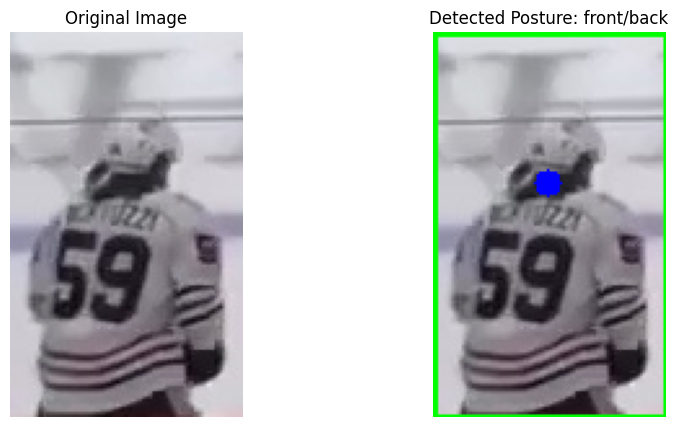

Detected player posture: front/back


In [25]:
# lets check if the player is standing with its back to the camera
# if so, then the jersey number will be visible properly
# if the player is standing with its face to the camera, then the jersey number will not be visible.
# if the player is standing with its side to the camera, then the jersey number will be visible partially.


# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
# Apply threshold to get binary image
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
if not contours:
    print("No contours found")
    
# Get the largest contour (assuming it's the player)
player_contour = max(contours, key=cv2.contourArea)
    
# Get bounding rectangle
x, y, w, h = cv2.boundingRect(player_contour)
    
# Calculate aspect ratio
aspect_ratio = float(w) / h
    
# Calculate the orientation using PCA
moments = cv2.moments(player_contour)
if moments['m00'] != 0:
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
else:
    print("No contours found")
    
# Draw the results (for visualization)
result_img = img.copy()
cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2.circle(result_img, (cx, cy), 5, (0, 0, 255), -1)
print(f"Aspect ratio: {aspect_ratio}")
# Determine posture based on aspect ratio
if aspect_ratio < 0.65:  # tall and thin
    posture = "front/back"
elif aspect_ratio > 0.8:  # nearly square
    posture = "side"
else:
    posture = "diagonal"
    
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(122)
plt.imshow(result_img)
plt.title(f'Detected Posture: {posture}')
plt.axis('off')
plt.show()
    
print(f"Detected player posture: {posture}")


In [22]:
model = YOLO("../models/updated_model_with_jersey.pt")

detections = model.predict(img)

for detection in detections:
    cls_names = detection.names
    detection_supervision = sv.Detections.from_ultralytics(detection)
    
    # Get detected digits and their x-coordinates
    digits = []
    for i in range(len(detection_supervision.xyxy)):
        x1 = detection_supervision.xyxy[i][0]  # x coordinate of left side
        digit = detection_supervision.data['class_name'][i]
        digits.append((x1, digit))
    
    # Sort digits by x-coordinate (left to right)
    digits.sort(key=lambda x: x[0])
    
    # Combine digits into number
    jersey_number = ''.join(digit for _, digit in digits)
    
    print(f"Detected Jersey Number: {jersey_number}")
    


0: 640x416 1 5, 1 9, 472.8ms
Speed: 6.3ms preprocess, 472.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)
Detected Jersey Number: 59
